In [4]:
import matplotlib
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

plt.style.use('ggplot')
from transformers import  BertTokenizer,DistilBertTokenizer, RobertaModel, RobertaTokenizer
from transformers import  AdamW, get_linear_schedule_with_warmup
import torch

from torch import nn
from sklearn.model_selection import train_test_split
import os
import sys
import pandas as pd

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler 


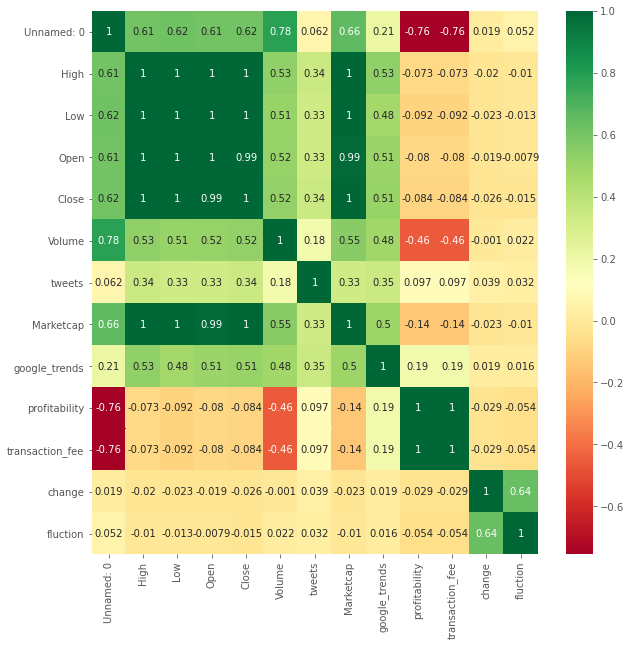

In [5]:
filepath = f"./data/BTC_Data.csv"
keys = ['High', 'Low', 'Open', 'Close', 'Volume', 'tweets','Marketcap', 'google_trends', 'profitability', 'transaction_fee']
targets = ["fluction"]
BTC_df = pd.read_csv(filepath, infer_datetime_format=True,
                         parse_dates=True)
BTC_df=BTC_df.fillna(0)
corrmat = BTC_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
ax=sns.heatmap(BTC_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.show()

# top: "change","transaction_fee","profitablity","volume","tweets","google_trends","close"

In [6]:

BTC_df=BTC_df.set_index("Date")
keys=['Close', 'Volume', 'tweets', 'google_trends', 'profitability', 'transaction_fee', 'fluction']
series = BTC_df[keys] 
# Picking the series with high correlation
print(series.shape)
series.tail(2)


(1009, 7)


,Close,Volume,tweets,google_trends,profitability,transaction_fee,fluction
Date,,,,,,,
2020-12-13,19142.382534,2.545047e+10,39491.0,61.014,0.140,0.140,0.00545
2020-12-14,19246.644341,2.247400e+10,38737.0,58.859,0.131,0.131,0.00000


## Price Predictions via three layers LSTM

In [124]:
%reload_ext autoreload
%autoreload 1
%aimport LSTM_pytorch
from sklearn.preprocessing import MinMaxScaler
from DataFun import plot_error,plot_data
import LSTM_pytorch


hidden_dim = 20
layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO N LAYER
output_dim = 1  # 2
seq_dim = 3
batch_size = 4

# keys = ['High', 'Low', 'Open', 'Close', 'Volume', 'tweets',
#         'Marketcap', 'google_trends', 'profitability', 'transaction_fee',
#         'fluction']  # ,'change','Date']
keys = ['Close', 'Volume', 'tweets', 'google_trends', 'profitability', 'transaction_fee', 'fluction']
targets = ["fluction"]
# ["change","fluction"]

scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, scaler) = LSTM_pytorch.dataloading(filepath=filepath,
                                                              keys=keys,
                                                              batch_size=batch_size,
                                                              targets=targets,
                                                              output_dim=output_dim,
                                                              window_size=seq_dim)
#LSTM(input_dim,train_loader, val_loader, hidden_dim, layer_dim, output_dim, seq_dim=7):
 
model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                 seq_dim=seq_dim,
                                                 train_loader=train_loader,
                                                 val_loader=val_loader,
                                                 hidden_dim=hidden_dim,
                                                 layer_dim=layer_dim,
                                                 output_dim=output_dim,
                                                 num_epochs = num_epochs)




/vol/fob-vol7/nebenf19/dingneng/ding_env/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0. Loss: 0.6003013162509255. val_loss: 0.5944882683031087.
Epoch: 10. Loss: 0.24541222382776484. val_loss: 0.2502075274616102.
Epoch: 20. Loss: 0.10015759661053278. val_loss: 0.10888614167793323.
Epoch: 30. Loss: 0.04209347683589281. val_loss: 0.04973258815422384.
Epoch: 40. Loss: 0.019422287086707464. val_loss: 0.026424376712328144.
Epoch: 50. Loss: 0.010596162089297074. val_loss: 0.015751270124254972.
Epoch: 60. Loss: 0.00728915346589703. val_loss: 0.011583576318379104.
Epoch: 70. Loss: 0.006014943031394588. val_loss: 0.009657786177026203.
Epoch: 80. Loss: 0.005523781283825103. val_loss: 0.009088412315615524.
Epoch: 90. Loss: 0.005335228630632266. val_loss: 0.008676717559857201.
Epoch: 100. Loss: 0.005253740829655681. val_loss: 0.008189345294938387.
Epoch: 110. Loss: 0.005221285190945202. val_loss: 0.008091809016352107.
Epoch: 120. Loss: 0.00524948960125771. val_loss: 0.008549561165509444.
Epoch: 130. Loss: 0.005307666622955491. val_loss: 0.008049465855729278.
Epoch: 140. Loss

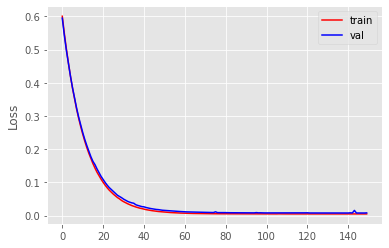

In [125]:
plot_error(train_loss,val_loss)

MSE = 0.052717894315719604
RMSE = 0.0
R-Squared Score = -40.34507892406727


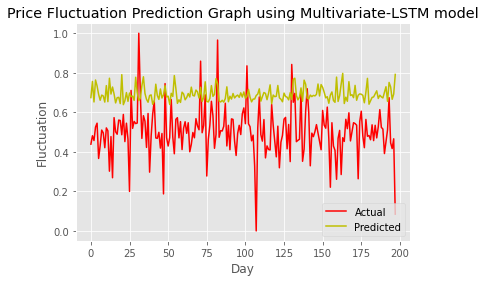

In [126]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
predicted, actual, mse, r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))

plot_data(actual,predicted)

In [ ]:
# # Save a model
#BTC_model.save('./model/LSTM_Vanilla_BTC.h5')
# #del model # Deletes the model
# # Load a model
# model = load_model('MV3-LSTM_50_[40,35]_1e-3_64.h5')

## price prediction model: three layer LSTM + sentiment indices from different "BERT" model

### LM

In [26]:
%reload_ext autoreload
%autoreload 1
%aimport LSTM_pytorch
from sklearn.preprocessing import MinMaxScaler
from DataFun import plot_error,plot_data
import LSTM_pytorch


hidden_dim = 20
layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO N LAYER
output_dim = 1  # 2
seq_dim = 3
batch_size = 4
num_epochs = 150

# keys = ['High', 'Low', 'Open', 'Close', 'Volume', 'tweets',
#         'Marketcap', 'google_trends', 'profitability', 'transaction_fee',
#         'fluction']  # ,'change','Date']

# ["change","fluction"]
file_sentiment=f'./data/LM_dic_sentiment.csv'
df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')

In [50]:
LM_df=pd.concat([df, sentiment['sentiment']], axis=1, join='inner')
keys = ['Close', 'Volume', 'tweets', 'google_trends', 'profitability', 'transaction_fee', 'fluction','sentiment']
targets = ["fluction"]
LM_df=LM_df[keys]
LM_df.tail(3)

,Close,Volume,tweets,google_trends,profitability,transaction_fee,fluction,sentiment
2020-12-12,18803.656870,2.175258e+10,38898.0,55.615,0.128,0.128,0.01801,0.020408
2020-12-13,19142.382534,2.545047e+10,39491.0,61.014,0.140,0.140,0.00545,0.072727
2020-12-14,19246.644341,2.247400e+10,38737.0,58.859,0.131,0.131,0.00000,-0.051429


In [39]:

scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, scaler) = LSTM_pytorch.dataloading(
                                                    df=LM_df,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)
#LSTM(input_dim,train_loader, val_loader, hidden_dim, layer_dim, output_dim, seq_dim=7):
 
model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                 seq_dim=seq_dim,
                                                 train_loader=train_loader,
                                                 val_loader=val_loader,
                                                 hidden_dim=hidden_dim,
                                                 layer_dim=layer_dim,
                                                 output_dim=output_dim,
                                                 num_epochs = 50)

/vol/fob-vol7/nebenf19/dingneng/ding_env/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0. Loss: 0.6362850534010537. val_loss: 0.632642540543606.
Epoch: 1. Loss: 0.5890703865244419. val_loss: 0.5879351416676155.
Epoch: 2. Loss: 0.5463653914158857. val_loss: 0.5441630380014755.
Epoch: 3. Loss: 0.5048337739102448. val_loss: 0.5047063036150627.
Epoch: 4. Loss: 0.4673953444897374. val_loss: 0.4673741164520542.
Epoch: 5. Loss: 0.43279187211507486. val_loss: 0.43505861616223457.
Epoch: 6. Loss: 0.4007388332599326. val_loss: 0.4031886241690928.
Epoch: 7. Loss: 0.3714103762862049. val_loss: 0.37397234787132466.
Epoch: 8. Loss: 0.34465637256073045. val_loss: 0.3470324226827199.
Epoch: 9. Loss: 0.3190789215172393. val_loss: 0.3219206628522723.
Epoch: 10. Loss: 0.2948749462449098. val_loss: 0.2982692247845352.
Epoch: 11. Loss: 0.27387464414291746. val_loss: 0.2781423107336431.
Epoch: 12. Loss: 0.2537064376888396. val_loss: 0.25822171026039326.
Epoch: 13. Loss: 0.23486280450715294. val_loss: 0.23978999245404187.
Epoch: 14. Loss: 0.2181682614963266. val_loss: 0.2238625385347166

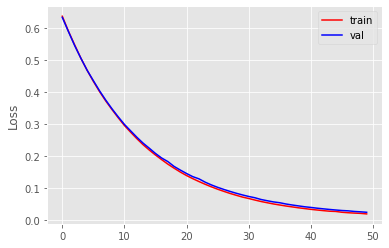

In [40]:
plot_error(train_loss,val_loss)

MSE = 0.016310108825564384
RMSE = 0.0
R-Squared Score = -70.94381977205313


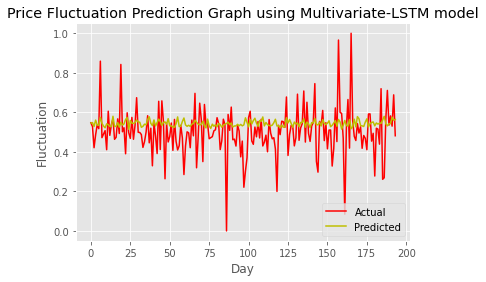

In [41]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
predicted, actual, mse, r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))
plot_data(actual,predicted)

### RoBERTa

In [75]:

hidden_dim = 20
layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO N LAYER
output_dim = 1  # 2
seq_dim = 3
batch_size = 4
num_epochs = 150

# keys = ['High', 'Low', 'Open', 'Close', 'Volume', 'tweets',
#         'Marketcap', 'google_trends', 'profitability', 'transaction_fee',
#         'fluction']  # ,'change','Date']

# ["change","fluction"]
file_sentiment=f'./data/_roberta_fold_9_sentiment.csv'
df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')

In [79]:
RoBERTa_df=pd.concat([df, sentiment],axis=1, join='inner')
RoBERTa_df.tail(3)

,Unnamed: 0,High,Low,Open,Close,Volume,tweets,Marketcap,google_trends,profitability,transaction_fee,change,fluction,sentiment,preds
2020-12-12,1006,18919.551228,18046.040724,18051.319990,18803.656870,2.175258e+10,38898.0,3.491706e+11,55.615,0.128,0.128,1,0.01801,-0.030612,-0.171066
2020-12-13,1007,19381.535773,18734.332888,18806.766479,19142.382534,2.545047e+10,39491.0,3.554792e+11,61.014,0.140,0.140,1,0.00545,0.045455,0.203180
2020-12-14,1008,19305.100443,19012.709408,19144.492460,19246.644341,2.247400e+10,38737.0,3.574326e+11,58.859,0.131,0.131,0,0.00000,0.185714,0.713161


#### sentiment without probability 

In [83]:
keys = ['Close', 'Volume', 'tweets', 'google_trends', 'profitability', 'transaction_fee', 'fluction','sentiment']
targets = ["fluction"]
RoBERTa_df_sentiment=RoBERTa_df[keys]

scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, scaler) = LSTM_pytorch.dataloading(
                                                    df=RoBERTa_df,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)
#LSTM(input_dim,train_loader, val_loader, hidden_dim, layer_dim, output_dim, seq_dim=7):
 
model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                 seq_dim=seq_dim,
                                                 train_loader=train_loader,
                                                 val_loader=val_loader,
                                                 hidden_dim=hidden_dim,
                                                 layer_dim=layer_dim,
                                                 output_dim=output_dim,
                                                 num_epochs = num_epochs)

/vol/fob-vol7/nebenf19/dingneng/ding_env/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0. Loss: 0.31314546624316447. val_loss: 0.3109655885146015.
Epoch: 1. Loss: 0.2873047420495673. val_loss: 0.2871878641721659.
Epoch: 2. Loss: 0.26351248076822187. val_loss: 0.26386036446798256.
Epoch: 3. Loss: 0.24185589116208162. val_loss: 0.24307153654125183.
Epoch: 4. Loss: 0.221806361045264. val_loss: 0.22385793367916113.
Epoch: 5. Loss: 0.20366702219353447. val_loss: 0.20658823303493418.
Epoch: 6. Loss: 0.18648766938455497. val_loss: 0.1895268799365152.
Epoch: 7. Loss: 0.1708358479074285. val_loss: 0.17479805933482012.
Epoch: 8. Loss: 0.1570420964986463. val_loss: 0.1618756316226291.
Epoch: 9. Loss: 0.14386450206931634. val_loss: 0.1488711034225969.
Epoch: 10. Loss: 0.13189703848543047. val_loss: 0.13732415203146298.
Epoch: 11. Loss: 0.12115950646656978. val_loss: 0.1261863695125362.
Epoch: 12. Loss: 0.11099085655016235. val_loss: 0.1167534627340481.
Epoch: 13. Loss: 0.10150139505350136. val_loss: 0.10812683041286977.
Epoch: 14. Loss: 0.09325592184462879. val_loss: 0.099066

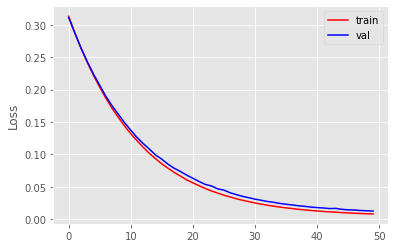

In [84]:
plot_error(train_loss,val_loss)

MSE = 0.028272613883018494
RMSE = 0.0
R-Squared Score = -45.20214058697938


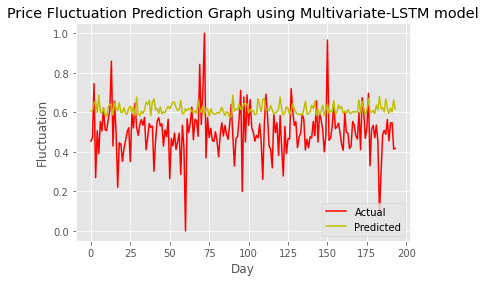

In [85]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
predicted, actual, mse, r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))
plot_data(actual,predicted)

#### sentiment with probabilities


In [86]:
keys = ['Close', 'Volume', 'tweets', 'google_trends', 'profitability', 'transaction_fee', 'fluction','preds']
targets = ["fluction"]
RoBERTa_df_preds=RoBERTa_df[keys]

scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, scaler) = LSTM_pytorch.dataloading(
                                                    df=RoBERTa_df,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)
#LSTM(input_dim,train_loader, val_loader, hidden_dim, layer_dim, output_dim, seq_dim=7):
 
model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                 seq_dim=seq_dim,
                                                 train_loader=train_loader,
                                                 val_loader=val_loader,
                                                 hidden_dim=hidden_dim,
                                                 layer_dim=layer_dim,
                                                 output_dim=output_dim,
                                                 num_epochs = num_epochs)

/vol/fob-vol7/nebenf19/dingneng/ding_env/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0. Loss: 0.309987561234945. val_loss: 0.26694027498548767.
Epoch: 1. Loss: 0.28375108577782593. val_loss: 0.24434439947921383.
Epoch: 2. Loss: 0.26089136453368994. val_loss: 0.22318519563746148.
Epoch: 3. Loss: 0.23957597728394256. val_loss: 0.20476413218306394.
Epoch: 4. Loss: 0.22001717220756073. val_loss: 0.18684134089209486.
Epoch: 5. Loss: 0.2027108369371559. val_loss: 0.17089193664431204.
Epoch: 6. Loss: 0.1853314796580544. val_loss: 0.15629620126667404.
Epoch: 7. Loss: 0.17085962219140197. val_loss: 0.1431704527216211.
Epoch: 8. Loss: 0.15664013677948638. val_loss: 0.1307871958676458.
Epoch: 9. Loss: 0.14419637662889082. val_loss: 0.11977920807557552.
Epoch: 10. Loss: 0.13241109289700473. val_loss: 0.10962354618964934.
Epoch: 11. Loss: 0.12170067886951604. val_loss: 0.10004296876997057.
Epoch: 12. Loss: 0.11234331626114966. val_loss: 0.09147116811246361.
Epoch: 13. Loss: 0.10287147630713409. val_loss: 0.08440626137889624.
Epoch: 14. Loss: 0.09557701060194758. val_loss: 0.

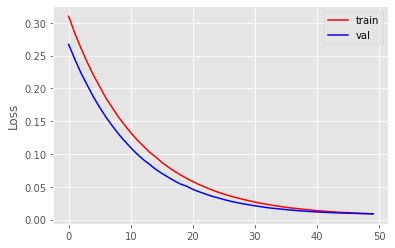

In [87]:
plot_error(train_loss,val_loss)

MSE = 0.027756227180361748
RMSE = 0.0
R-Squared Score = -41.69236015871951


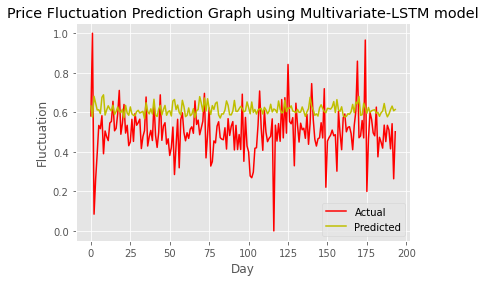

In [88]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
predicted, actual, mse, r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))
plot_data(actual,predicted)

### DistilBERT


In [ ]:

hidden_dim = 20
layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO N LAYER
output_dim = 1  # 2
seq_dim = 3
batch_size = 4
num_epochs = 150

file_sentiment=f'./data/_distilbert_fold_2_sentiment.csv'
df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')

In [90]:
Distil_df=pd.concat([df, sentiment],axis=1, join='inner')
Distil_df.tail(3)

,Unnamed: 0,High,Low,Open,Close,Volume,tweets,Marketcap,google_trends,profitability,transaction_fee,change,fluction,sentiment,preds
2020-12-12,1006,18919.551228,18046.040724,18051.319990,18803.656870,2.175258e+10,38898.0,3.491706e+11,55.615,0.128,0.128,1,0.01801,-0.030612,-0.171066
2020-12-13,1007,19381.535773,18734.332888,18806.766479,19142.382534,2.545047e+10,39491.0,3.554792e+11,61.014,0.140,0.140,1,0.00545,0.045455,0.203180
2020-12-14,1008,19305.100443,19012.709408,19144.492460,19246.644341,2.247400e+10,38737.0,3.574326e+11,58.859,0.131,0.131,0,0.00000,0.185714,0.713161


#### sentiment without probabilities

In [102]:
keys = ['Close', 'Volume', 'tweets', 'google_trends', 
        'profitability', 'transaction_fee', 'fluction','sentiment']
targets = ["fluction"]
Distil_df_sentiment=Distil_df[keys]

scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, scaler) = LSTM_pytorch.dataloading(
                                                    df=Distil_df_sentiment,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)
 
model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                 seq_dim=seq_dim,
                                                 train_loader=train_loader,
                                                 val_loader=val_loader,
                                                 hidden_dim=hidden_dim,
                                                 layer_dim=layer_dim,
                                                 output_dim=output_dim,
                                                 num_epochs = num_epochs)

/vol/fob-vol7/nebenf19/dingneng/ding_env/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0. Loss: 0.35910357572609863. val_loss: 0.3445784477745967.
Epoch: 1. Loss: 0.3293877934353261. val_loss: 0.31530233158703835.
Epoch: 2. Loss: 0.30082817356797714. val_loss: 0.2890064573488075.
Epoch: 3. Loss: 0.27656071236993696. val_loss: 0.26340859618137547.
Epoch: 4. Loss: 0.25352801476852804. val_loss: 0.24187202526445364.
Epoch: 5. Loss: 0.2324330900100213. val_loss: 0.22211074370643907.
Epoch: 6. Loss: 0.21240572603065758. val_loss: 0.20277501318210903.
Epoch: 7. Loss: 0.19527550013382225. val_loss: 0.18584819106365824.
Epoch: 8. Loss: 0.17880578438126588. val_loss: 0.17010679655258196.
Epoch: 9. Loss: 0.1645787152214141. val_loss: 0.15601980587009306.
Epoch: 10. Loss: 0.15055615629387809. val_loss: 0.14313644855378274.
Epoch: 11. Loss: 0.13817006554690342. val_loss: 0.13115706596807591.
Epoch: 12. Loss: 0.12664312114821205. val_loss: 0.12071575282631808.
Epoch: 13. Loss: 0.11627472010500069. val_loss: 0.11226392498556455.
Epoch: 14. Loss: 0.10679781705706934. val_loss: 0

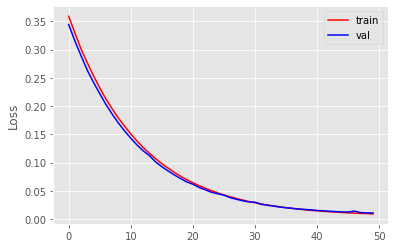

In [103]:
plot_error(train_loss,val_loss)

MSE = 0.02827565185725689
RMSE = 0.0
R-Squared Score = -28.997355029163234


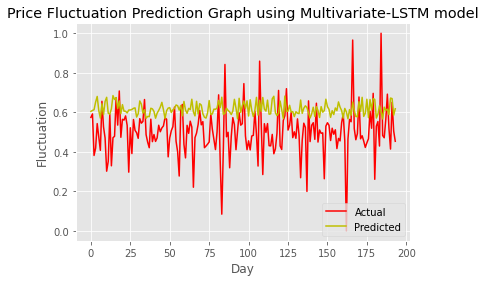

In [104]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
predicted, actual, mse, r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))
plot_data(actual,predicted)

#### sentiment with probabilities

In [108]:
keys = ['Close', 'Volume', 'tweets', 'google_trends', 'profitability', 
        'transaction_fee', 'fluction','preds']
targets = ["fluction"]
Distil_df_preds=Distil_df[keys]

scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, scaler) = LSTM_pytorch.dataloading(
                                                    df=RoBERTa_df,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)
#LSTM(input_dim,train_loader, val_loader, hidden_dim, layer_dim, output_dim, seq_dim=7):
 
model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                 seq_dim=seq_dim,
                                                 train_loader=train_loader,
                                                 val_loader=val_loader,
                                                 hidden_dim=hidden_dim,
                                                 layer_dim=layer_dim,
                                                 output_dim=output_dim,
                                                 num_epochs = num_epochs)

/vol/fob-vol7/nebenf19/dingneng/ding_env/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0. Loss: 0.3296256143646904. val_loss: 0.33155846881094686.
Epoch: 1. Loss: 0.30550601748348793. val_loss: 0.30782247870625207.
Epoch: 2. Loss: 0.28309909914490544. val_loss: 0.2867907452096982.
Epoch: 3. Loss: 0.26224594384054595. val_loss: 0.2672788714763731.
Epoch: 4. Loss: 0.24308421783432177. val_loss: 0.24740526720590544.
Epoch: 5. Loss: 0.22558127324792404. val_loss: 0.23307078431122372.
Epoch: 6. Loss: 0.2093625578887855. val_loss: 0.21427878725058186.
Epoch: 7. Loss: 0.19325744122549704. val_loss: 0.20005396781716994.
Epoch: 8. Loss: 0.17975487262953685. val_loss: 0.185692013840868.
Epoch: 9. Loss: 0.16683576317339005. val_loss: 0.17409521655666185.
Epoch: 10. Loss: 0.1547643268787408. val_loss: 0.16180741601490162.
Epoch: 11. Loss: 0.14321008324623108. val_loss: 0.15032791607309606.
Epoch: 12. Loss: 0.13330341154072858. val_loss: 0.14019068538881338.
Epoch: 13. Loss: 0.12365020858713344. val_loss: 0.13199426192378536.
Epoch: 14. Loss: 0.11492903801742234. val_loss: 0.1

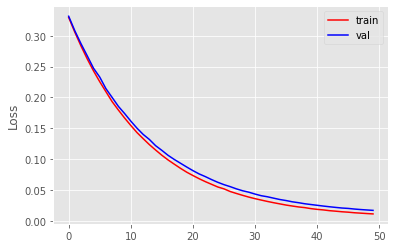

In [109]:
plot_error(train_loss,val_loss)

MSE = 0.021773716434836388
RMSE = 0.0
R-Squared Score = -512.64897121958


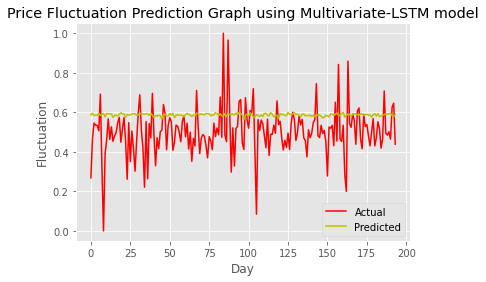

In [110]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
predicted, actual, mse, r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))
plot_data(actual,predicted)

### FinBERT

In [ ]:

hidden_dim = 20
layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO N LAYER
output_dim = 1  # 2
seq_dim = 3
batch_size = 4
num_epochs = 150

file_sentiment=f'./data/FinBert_pre_sentiment.csv'
df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')

In [111]:
FinBERT_df=pd.concat([df, sentiment],axis=1, join='inner')
FinBERT_df.tail(3)

,Unnamed: 0,High,Low,Open,Close,Volume,tweets,Marketcap,google_trends,profitability,transaction_fee,change,fluction,sentiment,preds
2020-12-12,1006,18919.551228,18046.040724,18051.319990,18803.656870,2.175258e+10,38898.0,3.491706e+11,55.615,0.128,0.128,1,0.01801,-0.030612,-0.171066
2020-12-13,1007,19381.535773,18734.332888,18806.766479,19142.382534,2.545047e+10,39491.0,3.554792e+11,61.014,0.140,0.140,1,0.00545,0.045455,0.203180
2020-12-14,1008,19305.100443,19012.709408,19144.492460,19246.644341,2.247400e+10,38737.0,3.574326e+11,58.859,0.131,0.131,0,0.00000,0.185714,0.713161


#### sentiment without probability

In [118]:
keys = ['Close', 'Volume', 'tweets', 'google_trends', 'profitability', 
        'transaction_fee', 'fluction','sentiment']
targets = ["fluction"]
FinBERT_df_sentiment=FinBERT_df[keys]

scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, scaler) = LSTM_pytorch.dataloading(
                                                    df=FinBERT_df_sentiment,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)
#LSTM(input_dim,train_loader, val_loader, hidden_dim, layer_dim, output_dim, seq_dim=7):
 
model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                 seq_dim=seq_dim,
                                                 train_loader=train_loader,
                                                 val_loader=val_loader,
                                                 hidden_dim=hidden_dim,
                                                 layer_dim=layer_dim,
                                                 output_dim=output_dim,
                                                 num_epochs = num_epochs)

/vol/fob-vol7/nebenf19/dingneng/ding_env/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0. Loss: 0.34052549764702594. val_loss: 0.3493297086419237.
Epoch: 1. Loss: 0.31494667711137214. val_loss: 0.3235048561260976.
Epoch: 2. Loss: 0.2900856934204886. val_loss: 0.30021713969218944.
Epoch: 3. Loss: 0.2682311827246147. val_loss: 0.2806947029689948.
Epoch: 4. Loss: 0.2479032882595364. val_loss: 0.25851545163261774.
Epoch: 5. Loss: 0.22876785167410404. val_loss: 0.23912447854244911.
Epoch: 6. Loss: 0.21140056202494645. val_loss: 0.22164691175232099.
Epoch: 7. Loss: 0.1954856047147437. val_loss: 0.20586287053979704.
Epoch: 8. Loss: 0.1806186405069466. val_loss: 0.19159791674478593.
Epoch: 9. Loss: 0.1665492127118986. val_loss: 0.17695890510349416.
Epoch: 10. Loss: 0.15426605232531512. val_loss: 0.1653153389563748.
Epoch: 11. Loss: 0.1428065017997464. val_loss: 0.153569283682287.
Epoch: 12. Loss: 0.1320873006140884. val_loss: 0.14208476835724498.
Epoch: 13. Loss: 0.12230407698905166. val_loss: 0.13236070145619838.
Epoch: 14. Loss: 0.11338295740417287. val_loss: 0.12322168

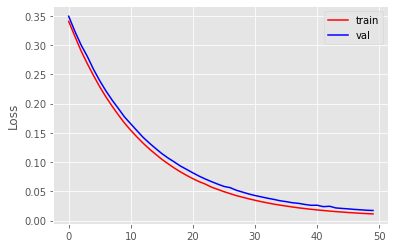

In [119]:
plot_error(train_loss,val_loss)

MSE = 0.024094969034194946
RMSE = 0.0
R-Squared Score = -32.26204821649071


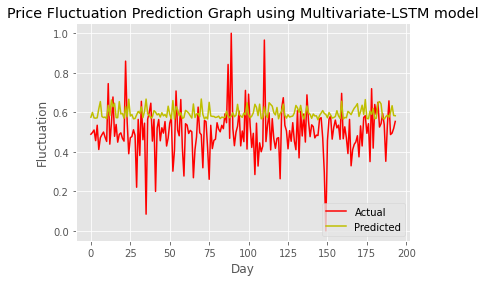

In [120]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
predicted, actual, mse, r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))
plot_data(actual,predicted)

#### sentiment with probabilities

In [115]:
keys = ['Close', 'Volume', 'tweets', 'google_trends', 'profitability', 'transaction_fee', 
        'fluction','preds']
targets = ["fluction"]
FinBERT_df_preds=FinBERT_df[keys]

scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, scaler) = LSTM_pytorch.dataloading(
                                                    df=FinBERT_df_preds,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)
#LSTM(input_dim,train_loader, val_loader, hidden_dim, layer_dim, output_dim, seq_dim=7):
 
model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                 seq_dim=seq_dim,
                                                 train_loader=train_loader,
                                                 val_loader=val_loader,
                                                 hidden_dim=hidden_dim,
                                                 layer_dim=layer_dim,
                                                 output_dim=output_dim,
                                                 num_epochs = num_epochs)

/vol/fob-vol7/nebenf19/dingneng/ding_env/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0. Loss: 0.2978667434823664. val_loss: 0.2850947566884097.
Epoch: 1. Loss: 0.275231843130498. val_loss: 0.2650224445593878.
Epoch: 2. Loss: 0.2546375333508359. val_loss: 0.24374749501836387.
Epoch: 3. Loss: 0.23573342899355706. val_loss: 0.22554758286183763.
Epoch: 4. Loss: 0.2174544523977026. val_loss: 0.20878936816145602.
Epoch: 5. Loss: 0.2016963381556016. val_loss: 0.19412917934385063.
Epoch: 6. Loss: 0.18629479134761834. val_loss: 0.1782927650476412.
Epoch: 7. Loss: 0.1723306916088243. val_loss: 0.16605329271850183.
Epoch: 8. Loss: 0.1597825552843794. val_loss: 0.1527685658824947.
Epoch: 9. Loss: 0.14781023642118973. val_loss: 0.1418224899693446.
Epoch: 10. Loss: 0.1371001479557798. val_loss: 0.1314187481698172.
Epoch: 11. Loss: 0.12664474839273887. val_loss: 0.12164486448311829.
Epoch: 12. Loss: 0.11728736649774298. val_loss: 0.11303658829149925.
Epoch: 13. Loss: 0.10846209389310849. val_loss: 0.1051028997387625.
Epoch: 14. Loss: 0.1005451364466284. val_loss: 0.09743158069

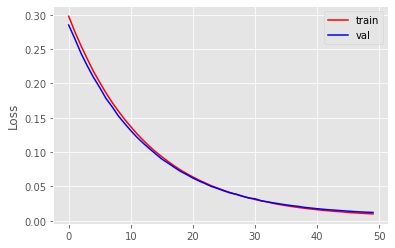

In [116]:
plot_error(train_loss,val_loss)

MSE = 0.024616451933979988
RMSE = 0.0
R-Squared Score = -128.10953973374117


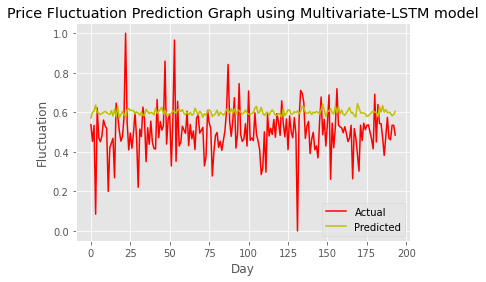

In [117]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
predicted, actual, mse, r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))
plot_data(actual,predicted)